In [1]:
library(ggplot2)
library(coda)
options(repr.plot.width = 25, repr.plot.height = 10)

# Exercise 1 #

given the following un-normalized posterior distribution:

$$
g(\theta \mid x) \propto \frac{1}{2} \exp -\frac{(\theta+3)^{2}}{2}+\frac{1}{2} \exp -\frac{(\theta-3)^{2}}{2}
$$

•draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm

•use a Norm (0,1) as random-walk candidate density

•plot the sampled distribution

$$
\rho = \frac{f(s)}{f(\theta _t)} \frac{Q(\theta _t|s)}{Q(s|\theta _t)}
$$

if $\rho \geq \mathcal{U}(1) $ -> accepted

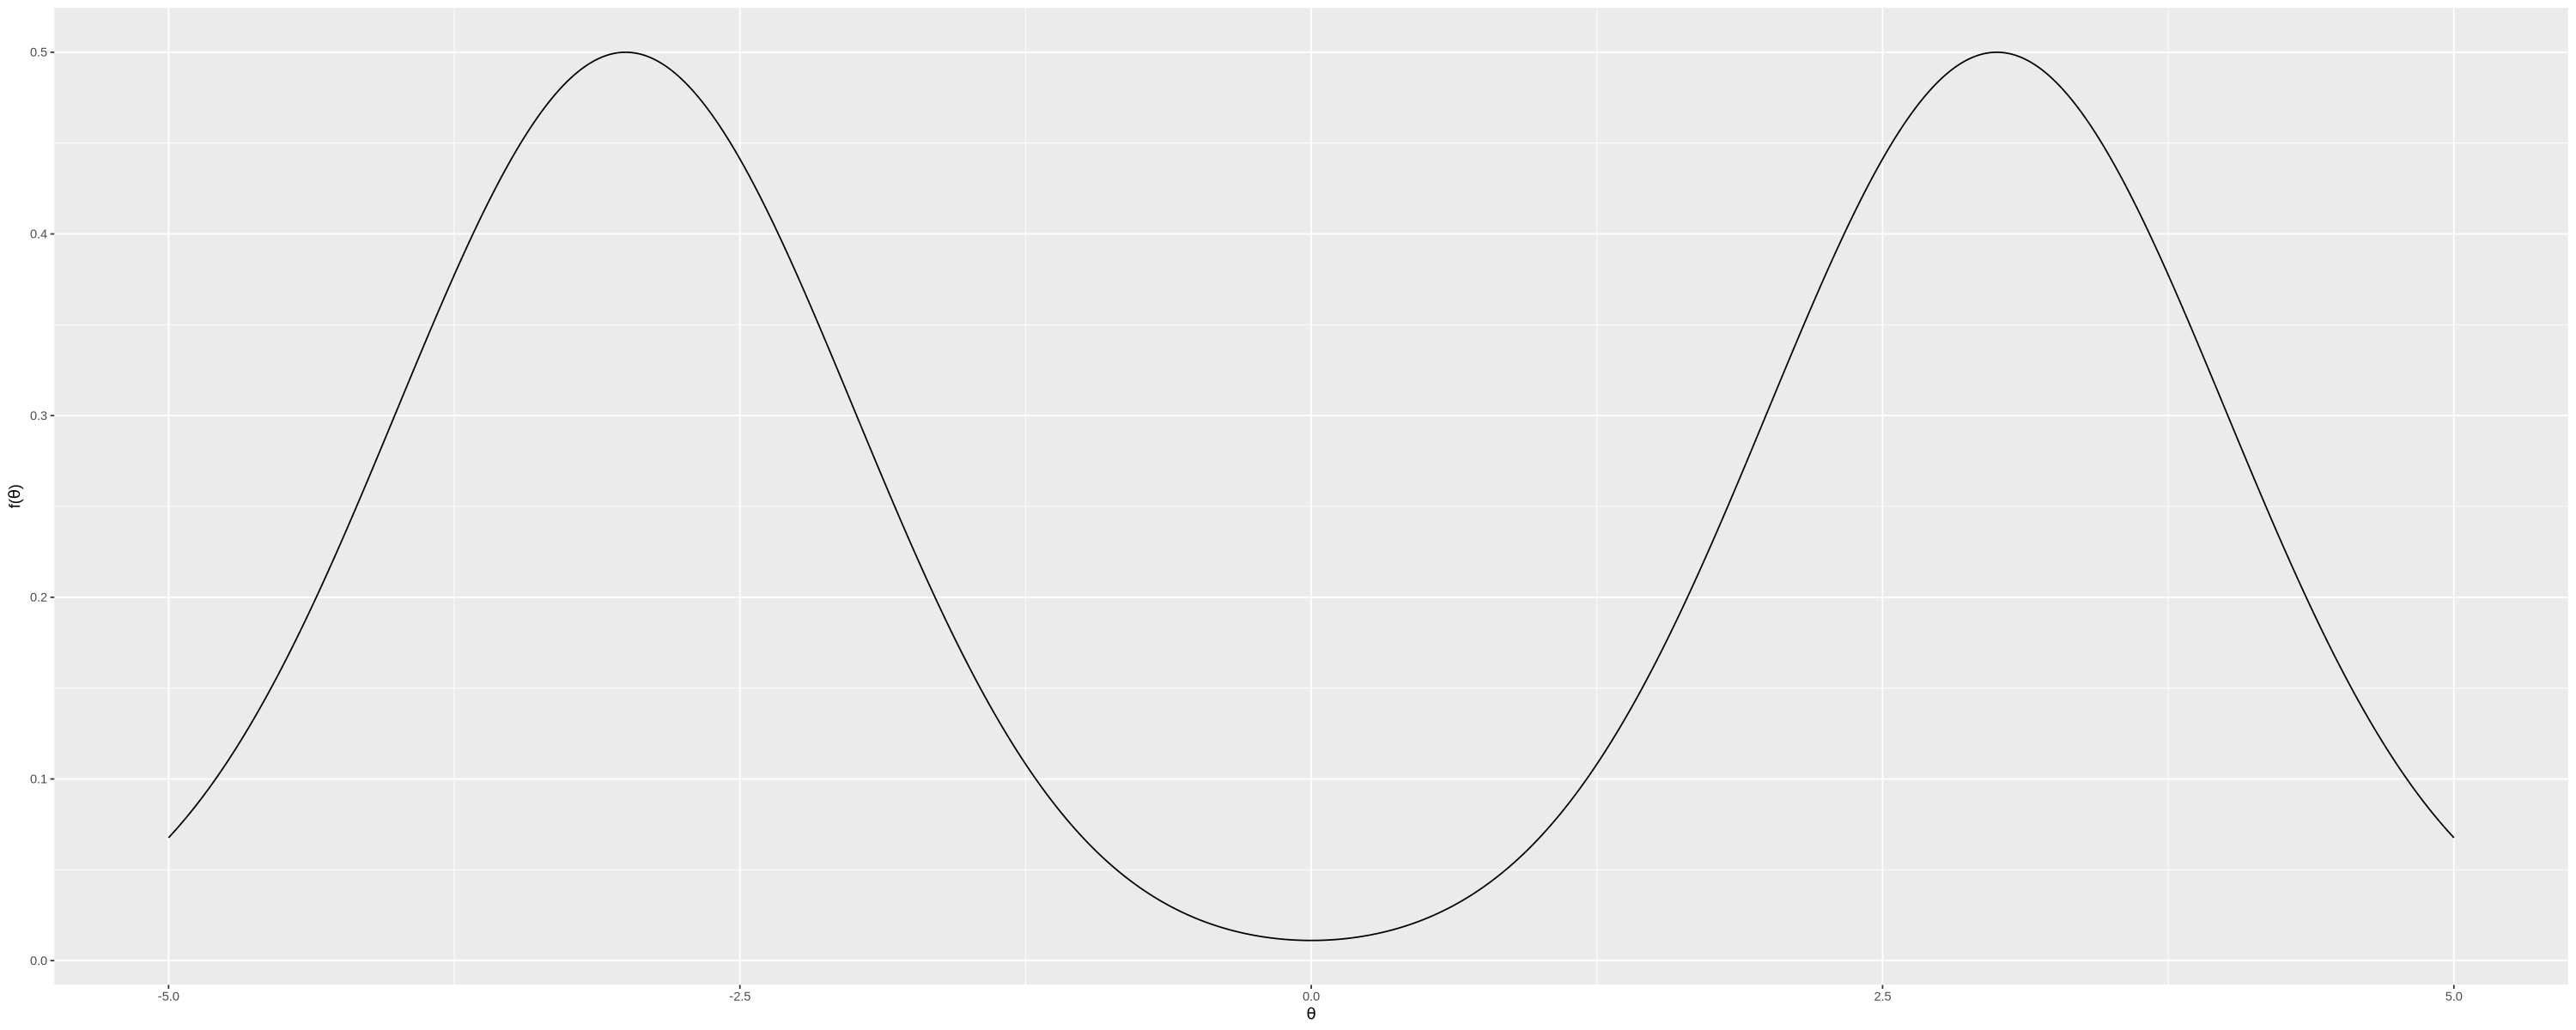

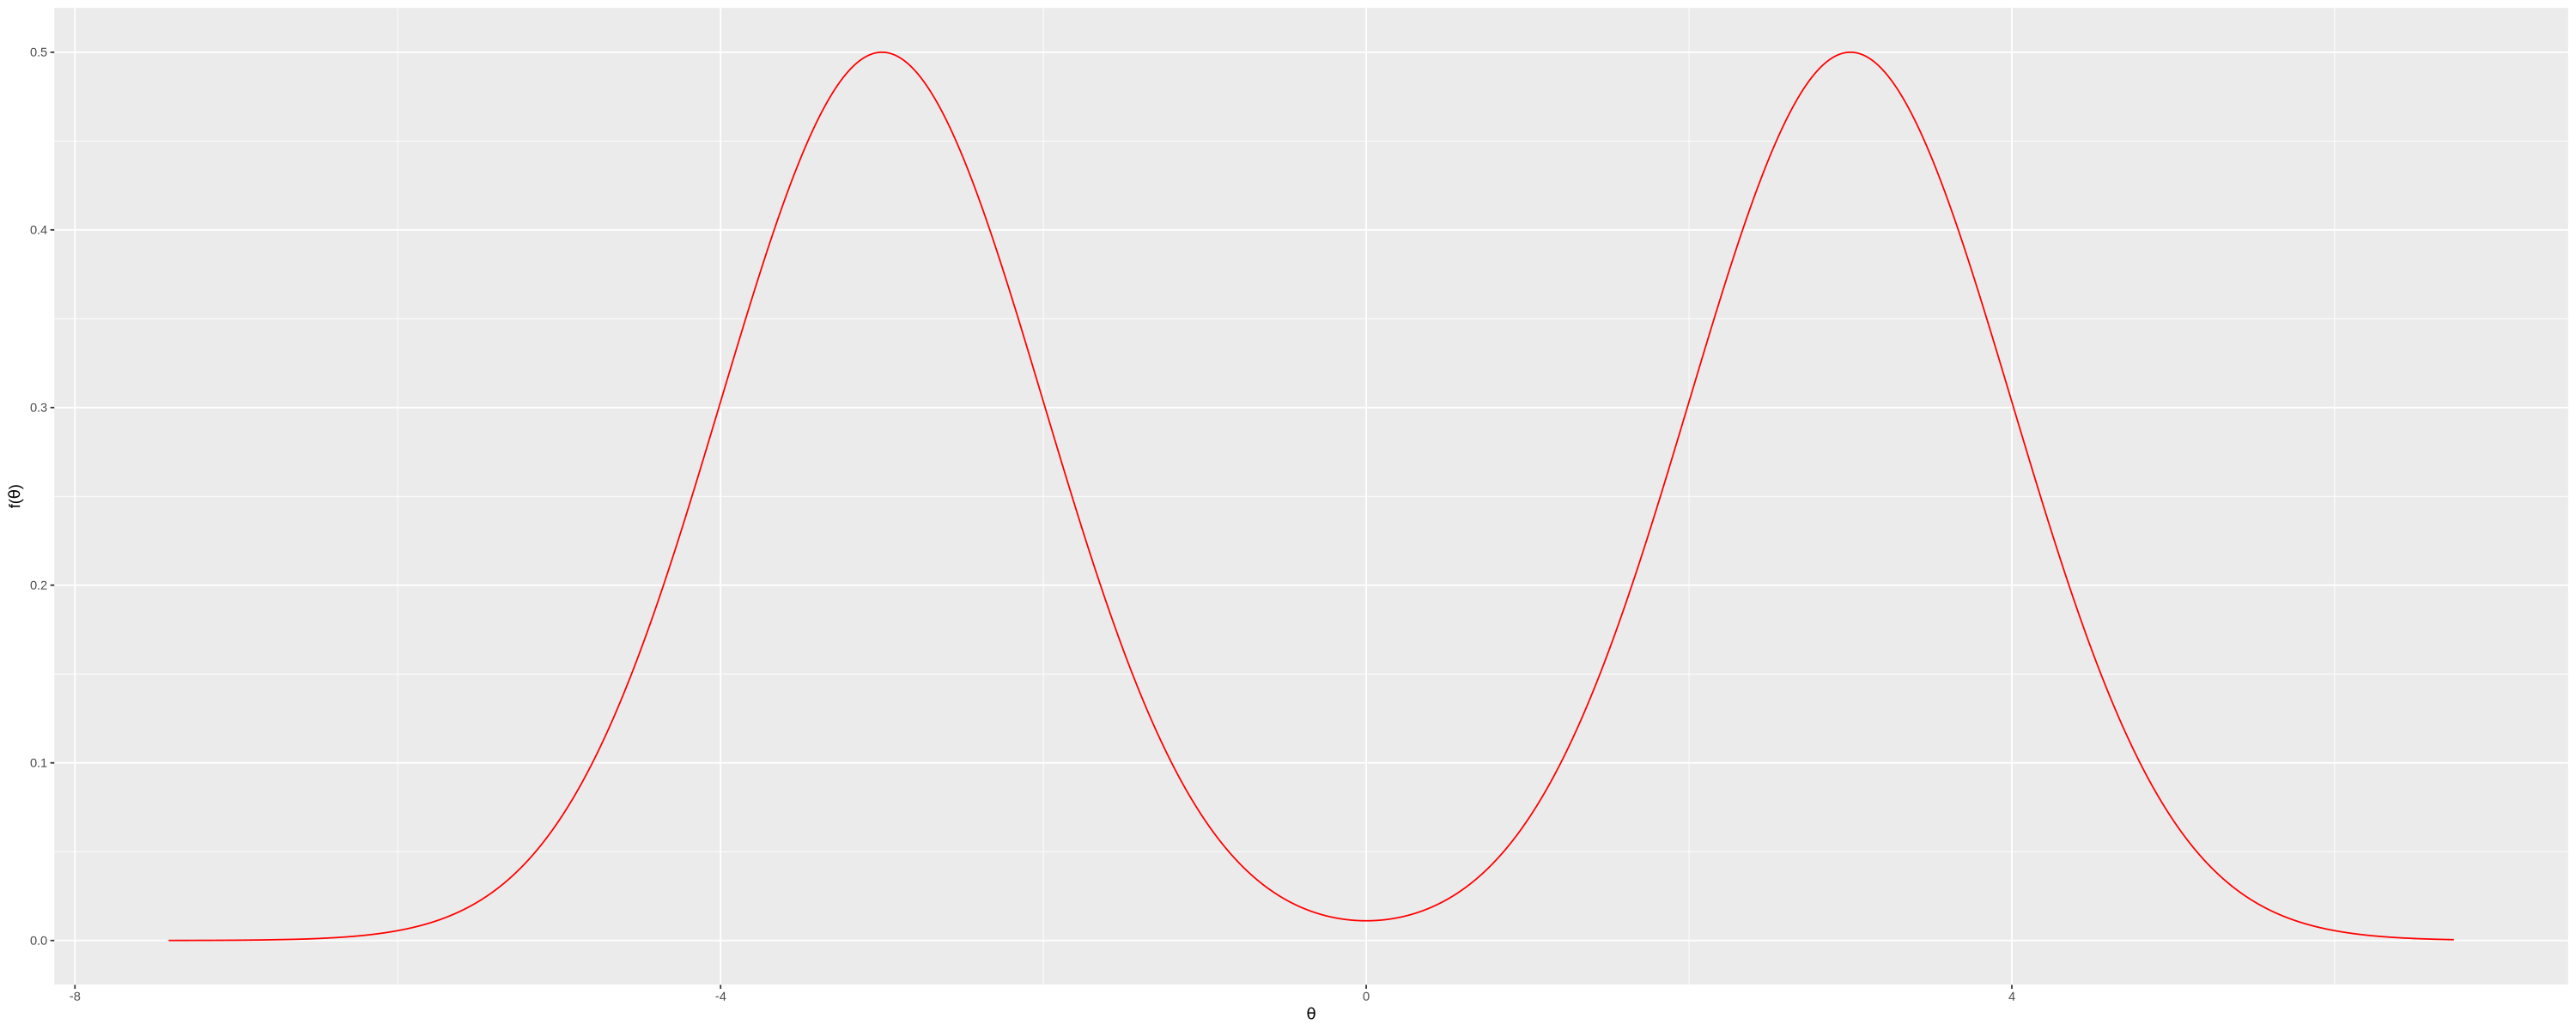

In [2]:
gfunc <- function(theta) {
    return(0.5 * exp(-((theta + 3)^2 / 2)) + 0.5 * exp(-(theta - 3)^2 / 2))
}

metropolis <- function(func, theta_init, n_samples) {
    # Initialization
    theta_curr <- theta_init
    func_curr <- func(theta_curr)
    func_samp <- matrix(data=NA, nrow=n_samples, ncol=2)
    #n_accept <- 0

    for (n in 1:n_samples) {
        # Extract the proposed state
        theta_prop <- rnorm(1, theta_curr, 1)
        func_prop <- func(theta_prop)
        Q_curr <- dnorm(theta_curr, theta_prop, 1) # Q(theta_t|s)
        Q_prop <- dnorm(theta_prop, theta_curr, 1) # Q(s|theta_t)
        rho <- (func_prop / func_curr) * (Q_curr / Q_prop) 

        if (rho >= runif(1)) {
            theta_curr <- theta_prop
            func_curr <- func_prop
            #n_accept <- n_accept + 1
        }
        func_samp[n, 1] <- func_curr
        func_samp[n, 2] <- theta_curr
    }
    return(func_samp)
}

# Plot the actual function
t = seq(-5, 5, length = 1e5)
df = data.frame(theta = t, func = gfunc(t))
#plot(t, log10(gfunc(t)), xlab = )
ggplot(df, aes(x = theta, y = func)) +
    geom_line(aes(x = theta, y = func)) +
    xlab(expression(theta)) + 
    ylab(expression(paste('f(',theta,')', sep='')))

# Testing
theta_init <- 1
n_samples <- 1e5

#set.seed(12345)
result <- metropolis(gfunc, theta_init, n_samples)
#result[, 1]
func_res = array(result[, 1])
theta_res = array(result[, 2])

#theta_space = seq(min(theta_res), max(theta_res), length = n_samples)
#print(theta_space)

# FIXA QUESTO !!!!
actual_func = gfunc(t) # dovresti usare theta_space ma crasha

#df_result = data.frame(theta_res = theta_res, func_res = func_res, actual_func = actual_func)

df_result = data.frame(theta_res = theta_res, func_res = func_res)
ggplot(df_result) +
    geom_line(aes(x = theta_res, y = func_res), color = 'red') +
    #geom_line(aes(x = theta_res, y = actual_func), color = 'blue') +
    xlab(expression(theta)) + 
    ylab(expression(paste('f(',theta,')', sep='')))
#plot(theta_res, func_res, xlab = expression(theta), ylab = expression(paste('f(',theta,')', sep='')))
#result


•analyze the chain with the CODA package and plot the chain autocorrelation

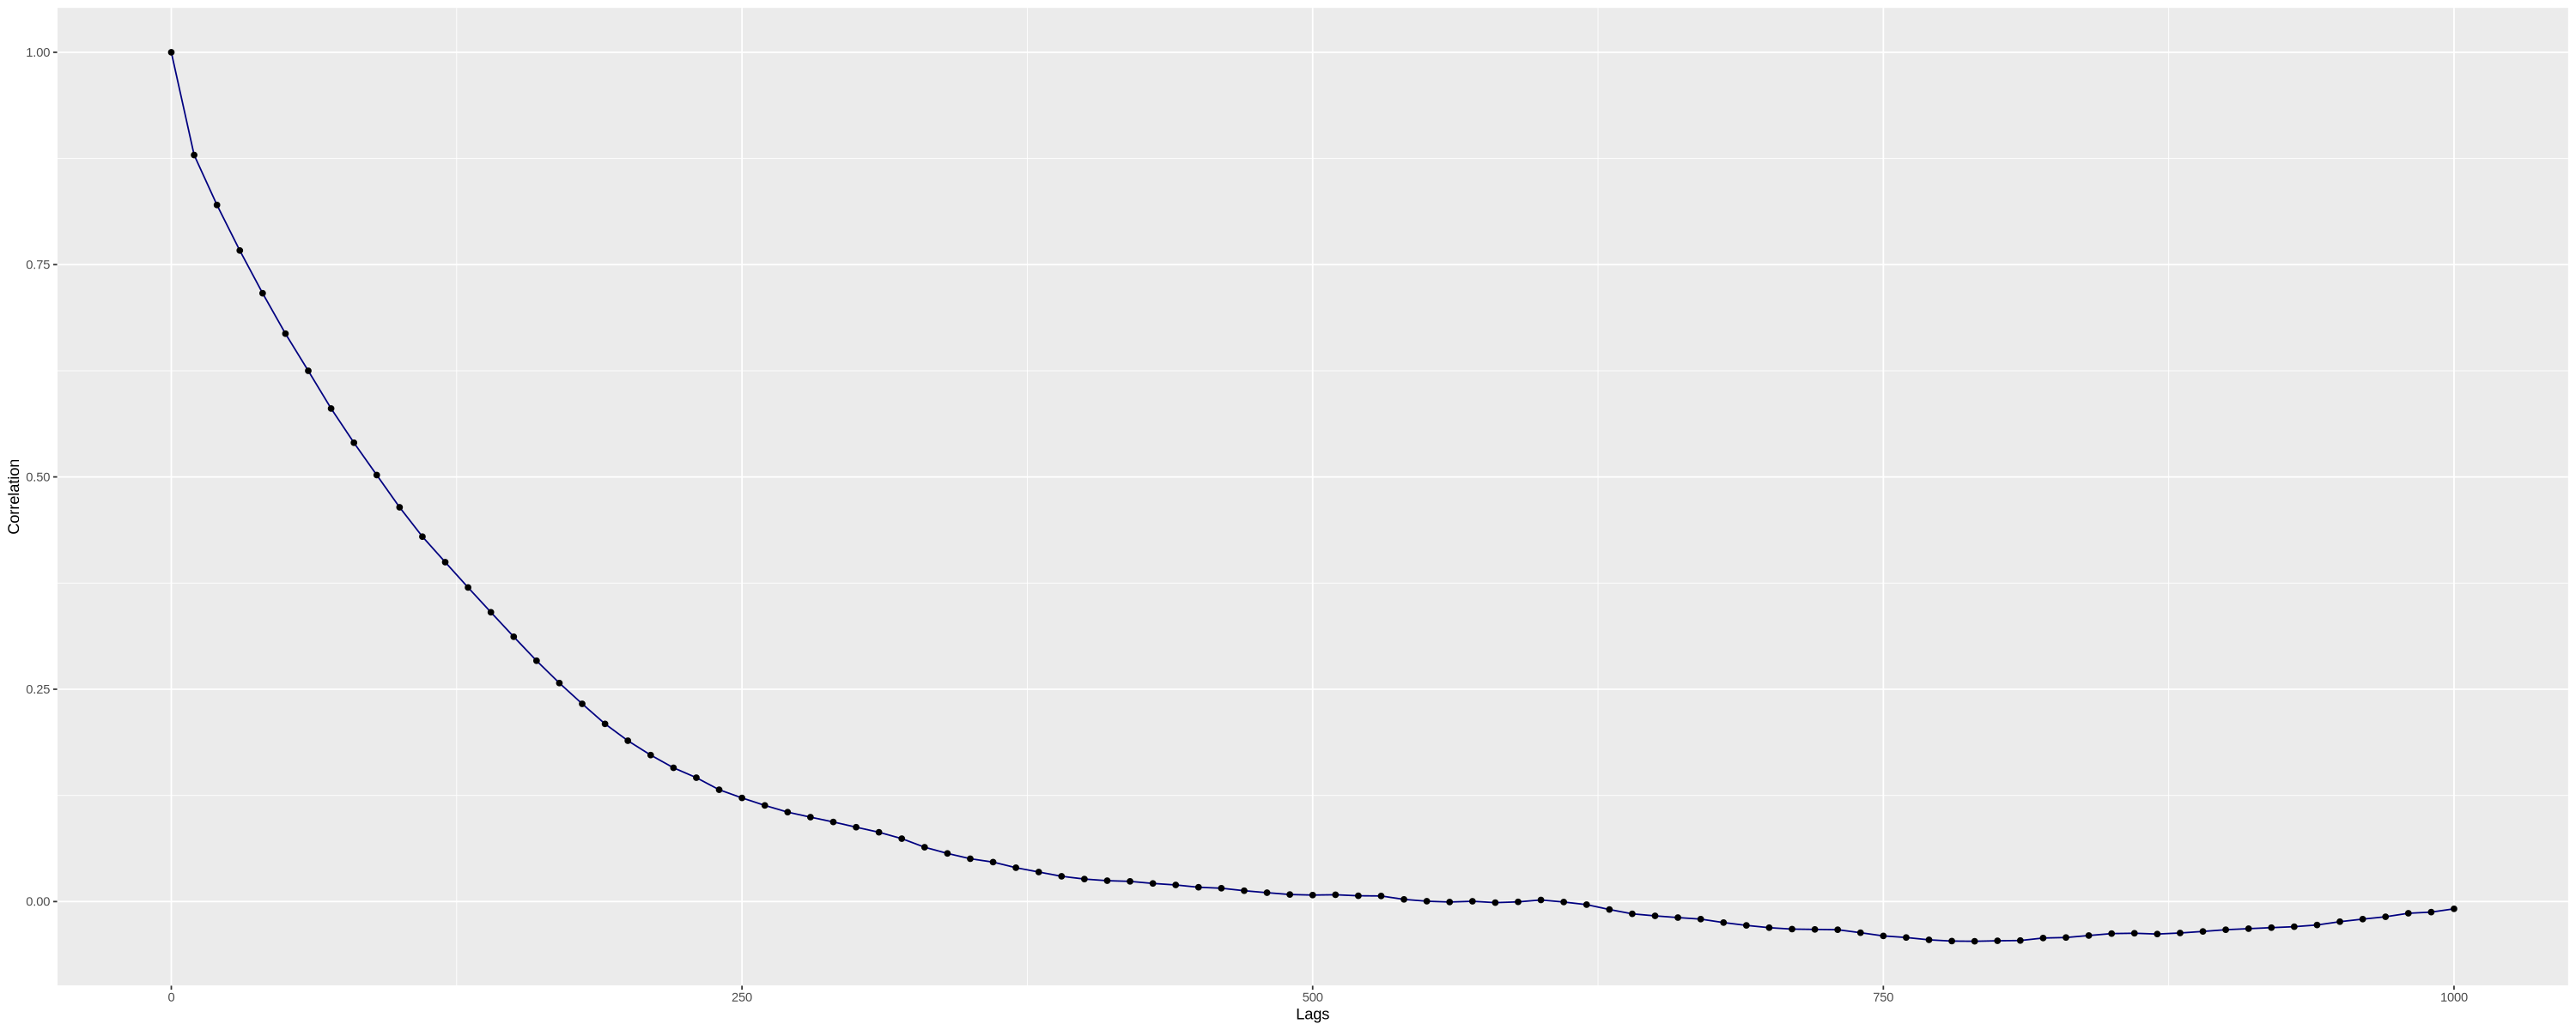

In [3]:
coda_chain = as.mcmc(theta_res)
#print(coda_chain)

lags = seq(0, 1000, 10)
corr = autocorr(coda_chain, lags)
#print(corr)

df = data.frame(lags = lags, corr = corr)

ggplot(df) +
    geom_line(aes(lags, corr), color = 'navyblue') +
    geom_point(aes(lags, corr)) +
    xlab("Lags") +
    ylab("Correlation")

•try to use different burn-in cycles and thinning and plot the corresponding posterior distribution
and the chain autocorrelation function. What are the best parameters ?

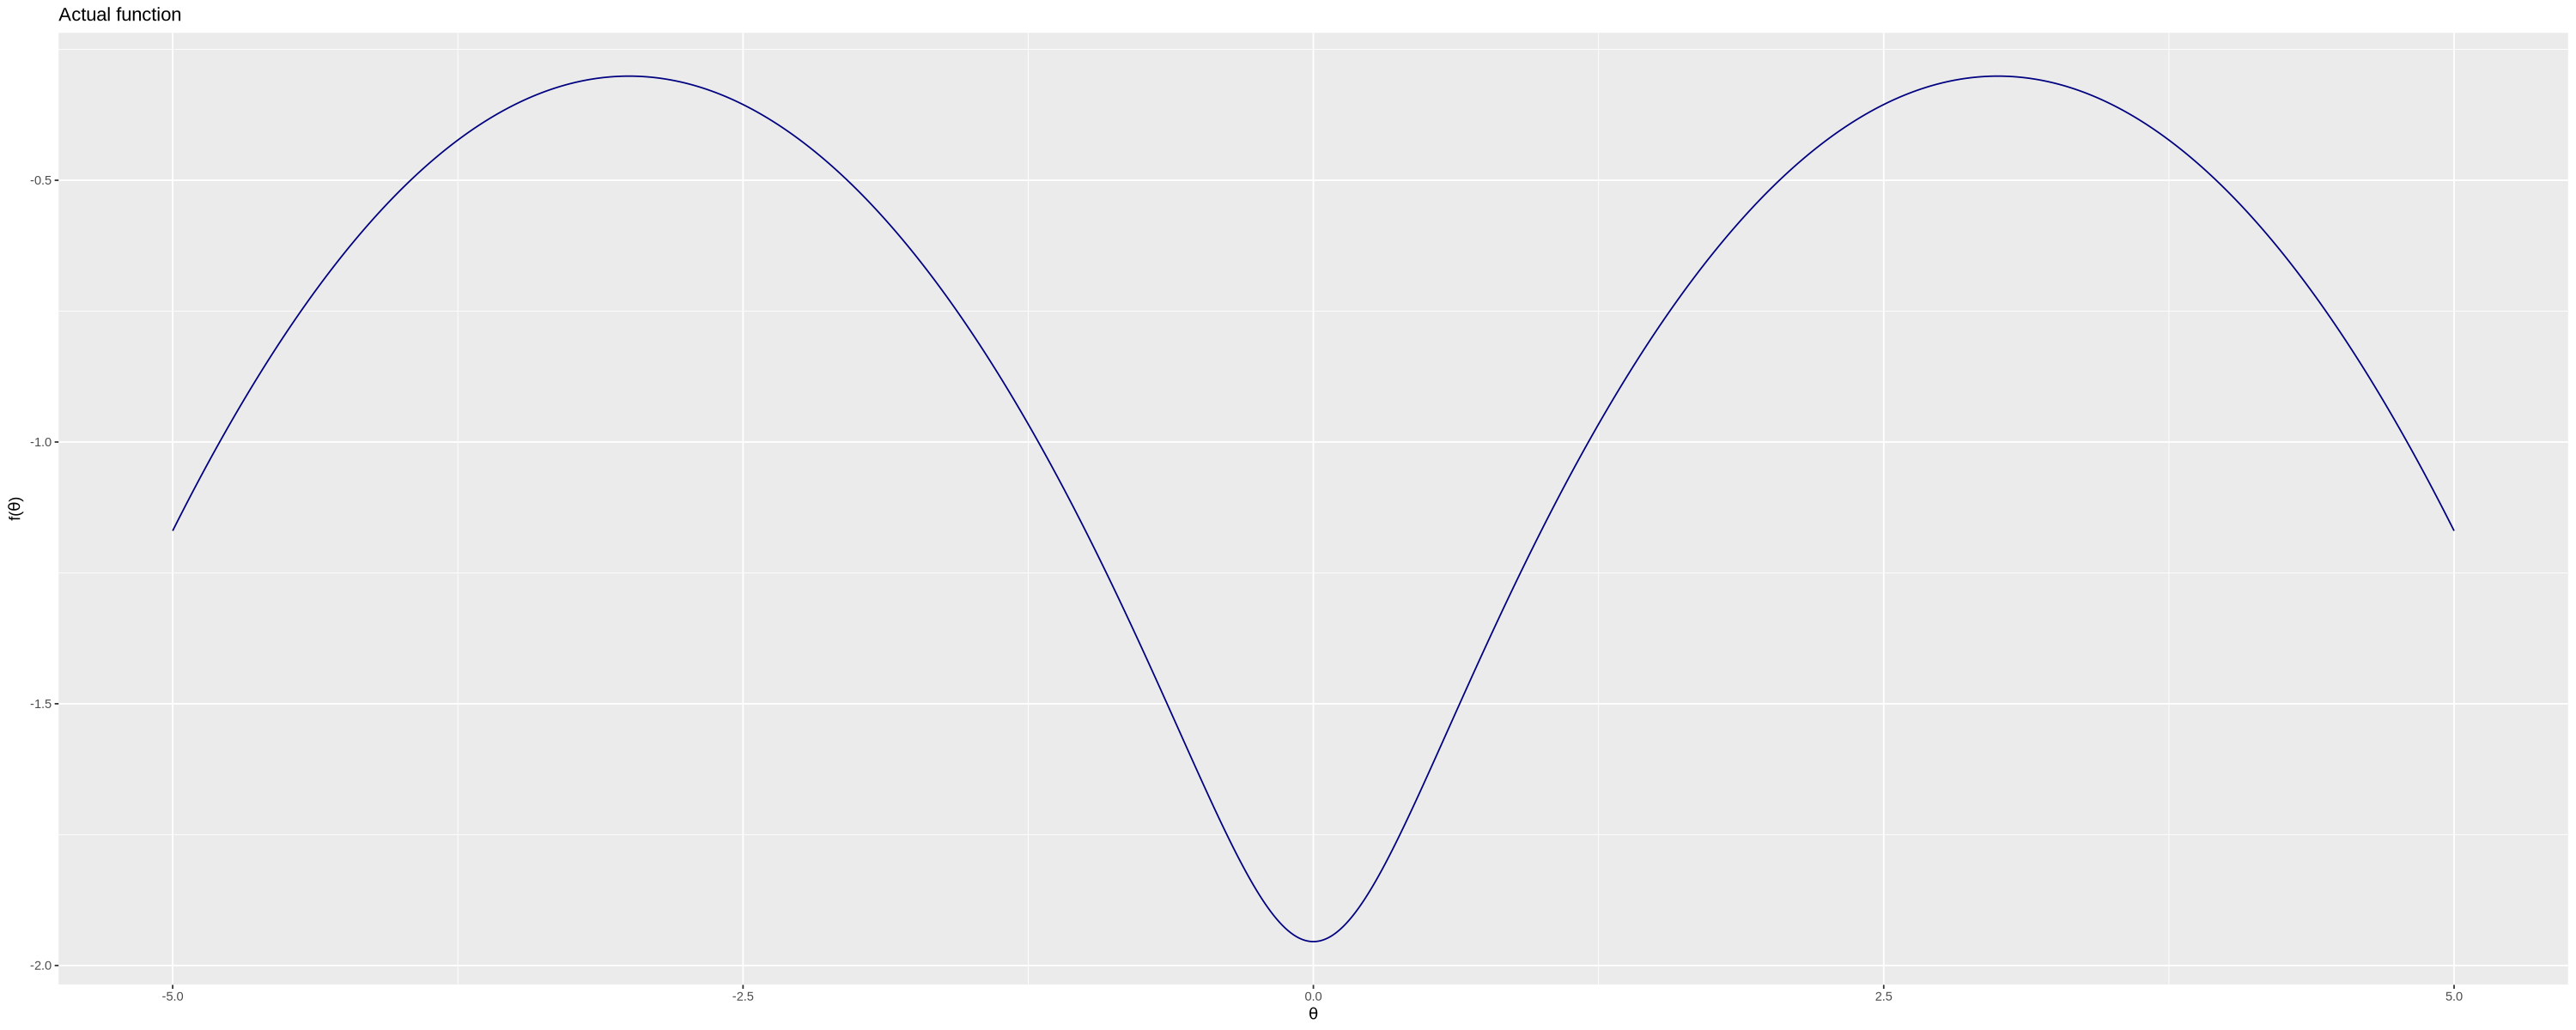

In [4]:
# Plot the actual function
t = seq(-5, 5, 10 / 1e5)
df = data.frame(theta = t, func = log10(gfunc(t)))
#plot(t, log10(gfunc(t)), xlab = )
ggplot(df, aes(x = theta, y = func)) +
    geom_line(aes(x = theta, y = func), color = 'navyblue') +
    labs(title = "Actual function") +
    xlab(expression(theta)) + 
    ylab(expression(paste('f(',theta,')', sep='')))

par(mfrow = c(2, 10))
n_samples <- 1e5
# Testing
for (theta in seq(-5, 5, 1)) {
    # Testing
    #print(theta)
    theta_init <- theta

    #set.seed(12345)
    result <- metropolis(gfunc, theta_init, n_samples)
    #result[, 1]
    func_res = array(result[, 1])
    theta_res = array(result[, 2])
    actual_func = gfunc(theta_res)
    df_result = data.frame(theta_res = theta_res, func_res = func_res, actual_func = actual_func)
    ggplot(df_result) +
        geom_line(aes(x = theta_res, y = func_res), color = 'red') +
        geom_line(aes(x = theta_res, y = actual_func), color = 'blue') +
        xlab(expression(theta)) + 
        ylab(expression(paste('f(',theta,')', sep='')))
    #plot(theta_res, func_res, xlab = expression(theta), ylab = expression(paste('f(',theta,')', sep='')))
    #result
}

,burn_in,thinning,effective_size
,<dbl>,<int>,<dbl>
var1,0,1,0.003723451
var11,200,1,0.003717865
var12,400,1,0.003705574
var13,600,1,0.003712481
var14,800,1,0.003721844
var15,1000,1,0.003728203
var16,0,2,0.007242181
var17,200,2,0.007199715
var18,400,2,0.007236261


[1] "The best params are: burn in = 400 , thinning = 1"


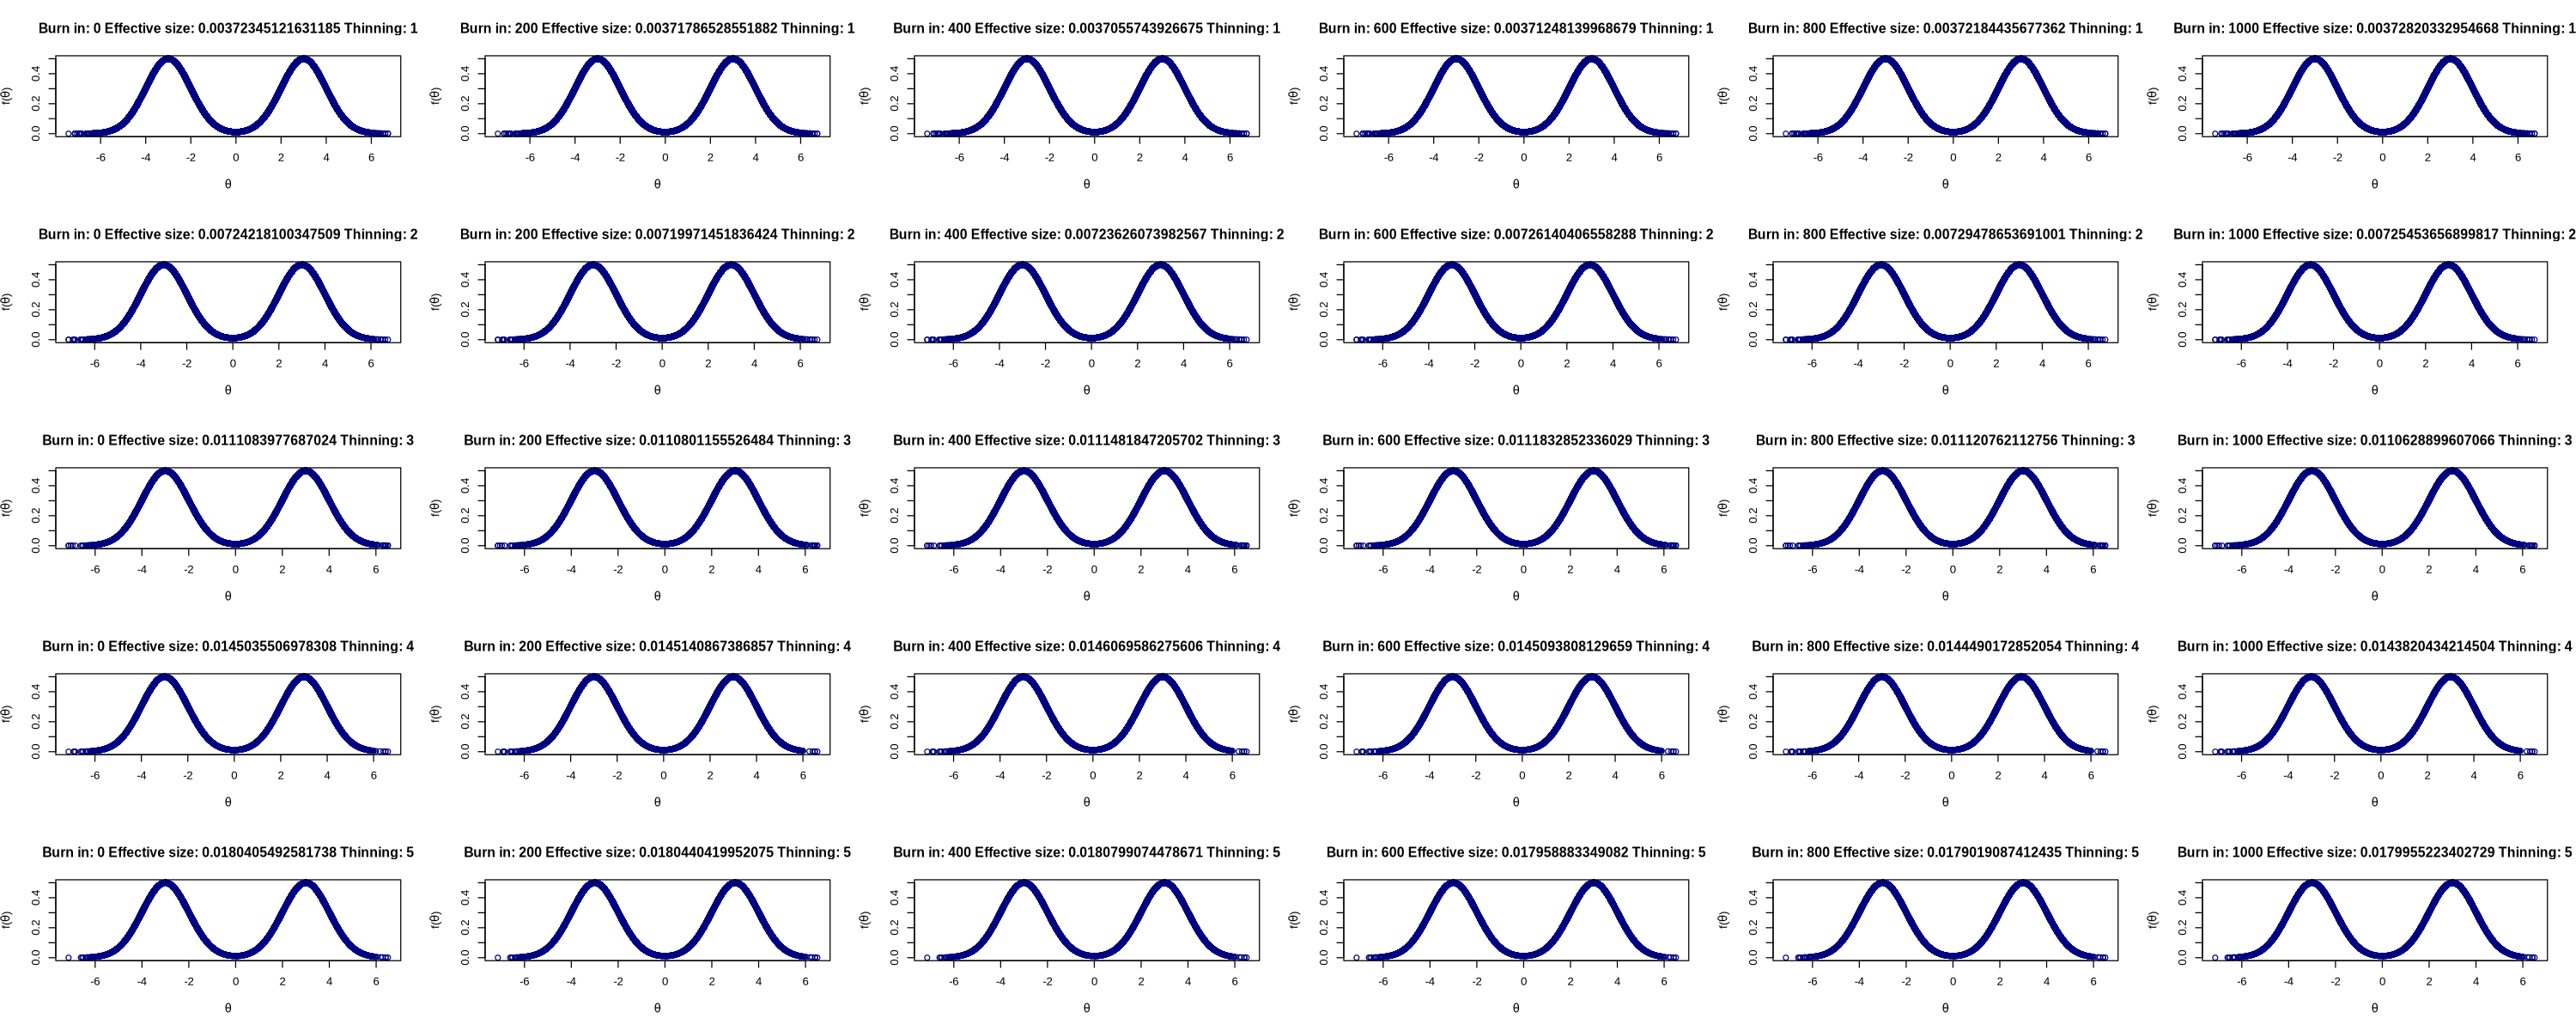

In [9]:
# Burn-in 
data = data.frame(burn_in = numeric(), thinning = numeric(), effective_size = numeric())
par(mfrow = c(5, 6))
for (thin in 1:5) {
    thinning = seq(1, n_samples, thin)
    coda_chain_thin = coda_chain[thinning]
    #print(coda_chain)
    for (n_burn_in in seq(0, 1000, 200)) {
        burnt_chain = coda_chain_thin[(n_burn_in + 1):n_samples]
        #print(dim(burnt_chain))

        # Remove NA values from burnt_chain
        burnt_chain <- burnt_chain[!is.na(burnt_chain)]

        #print(burnt_chain)

        eff_size = effectiveSize(burnt_chain) / length(burnt_chain)

        new_row = data.frame(burn_in = n_burn_in, thinning = thin, effective_size = eff_size)
        data = rbind(data, new_row)

        func_res = array(gfunc(burnt_chain))
        #print(dim(func_res))
        theta_res = array(burnt_chain)
        #print(dim(theta_res))
        plot(theta_res, func_res, main = paste("Burn in:", n_burn_in, "Effective size:", eff_size, "Thinning:", thin), 
            col = 'navyblue', xlab = expression(theta), ylab = expression(paste('f(',theta,')')))
    }
}
data
best_idx = which.min(data$effective_size)
best_params = c(data$burn_in[best_idx], data$thinning[best_idx])
print(paste("The best params are: burn in =", best_params[1], ", thinning =", best_params[2]))


In [6]:
a = c(0,1,2,3,4,5)
b = a[5:6]
print(b)

[1] 4 5


# Exercise 2 #

A set of measured data should follow, according to the physics model applied to them, a linear
behavior. Data are the following:

| $\mathrm{Y}$ | -7.821 | -1.494 | -15.444 | -10.807 | -13.735 | -14.442 | -15.892 | -18.326 |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| $\mathrm{X}$ | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 |

• perform a simple linear regression model running a Markov Chain Monte Carlo with JAGS, assuming
that data follow the model:

$$
(\mathrm{Z}[\mathrm{i}]=\mathrm{a}+\mathrm{b} * \mathrm{X}[\mathrm{i}])
$$